In [1]:
import pystare
import geopandas
import starepandas
import datetime
import matplotlib.pyplot as plt
import dask

In [2]:
# Load Country
countries = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
iceland = countries[countries.name=='Iceland']
sids = starepandas.sids_from_gdf(iceland, resolution=8, force_ccw=True)
iceland = starepandas.STAREDataFrame(iceland, sids=sids)

# Load Granule
fname = starepandas.datasets.get_path('MOD05_L2.A2019336.0000.061.2019336211522.hdf')
modis = starepandas.read_granule(fname, latlon=True, sidecar=True)
geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
modis.set_geometry(geom, inplace=True)

In [ ]:
# Recalculate
# modis.set_trixels(modis.make_trixels(),inplace=True)

In [3]:
sum(modis.stare_intersects(sids[0]))

1384

In [4]:
len(sids[0])

116

In [5]:
# STARE based intersects
sids_iceland = iceland['sids'].iloc[0]
sids_modis = list(modis['sids'])

start = datetime.datetime.now()
intersects_stare = pystare.intersects(sids_iceland, sids_modis)
print(datetime.datetime.now() - start)

0:00:00.165074


In [6]:
# Conventional shapely based instersects test.

# pygeos integration is still fragile but may speed up things 
geopandas.options.use_pygeos = False

start = datetime.datetime.now()
intersects = modis.intersects(iceland.geometry.iloc[0])
print(datetime.datetime.now() - start)

0:00:00.525143


In [7]:
iceland.set_trixels(iceland.make_trixels(),inplace=True)

In [8]:
# iceland.make_trixels()

In [11]:
iceland.trixels

144    MULTIPOLYGON (((-17.47089 63.57653, -16.74124 ...
Name: trixels, dtype: geometry

In [13]:
start = datetime.datetime.now()
modis.set_trixels(modis.make_trixels(),inplace=True)
print(datetime.datetime.now() - start)

0:00:31.430325


In [27]:
# geom = geopandas.points_from_xy(modis.lon, modis.lat, crs='EPSG:4326')
# modis.set_geometry(geom, inplace=True)

<AxesSubplot:>

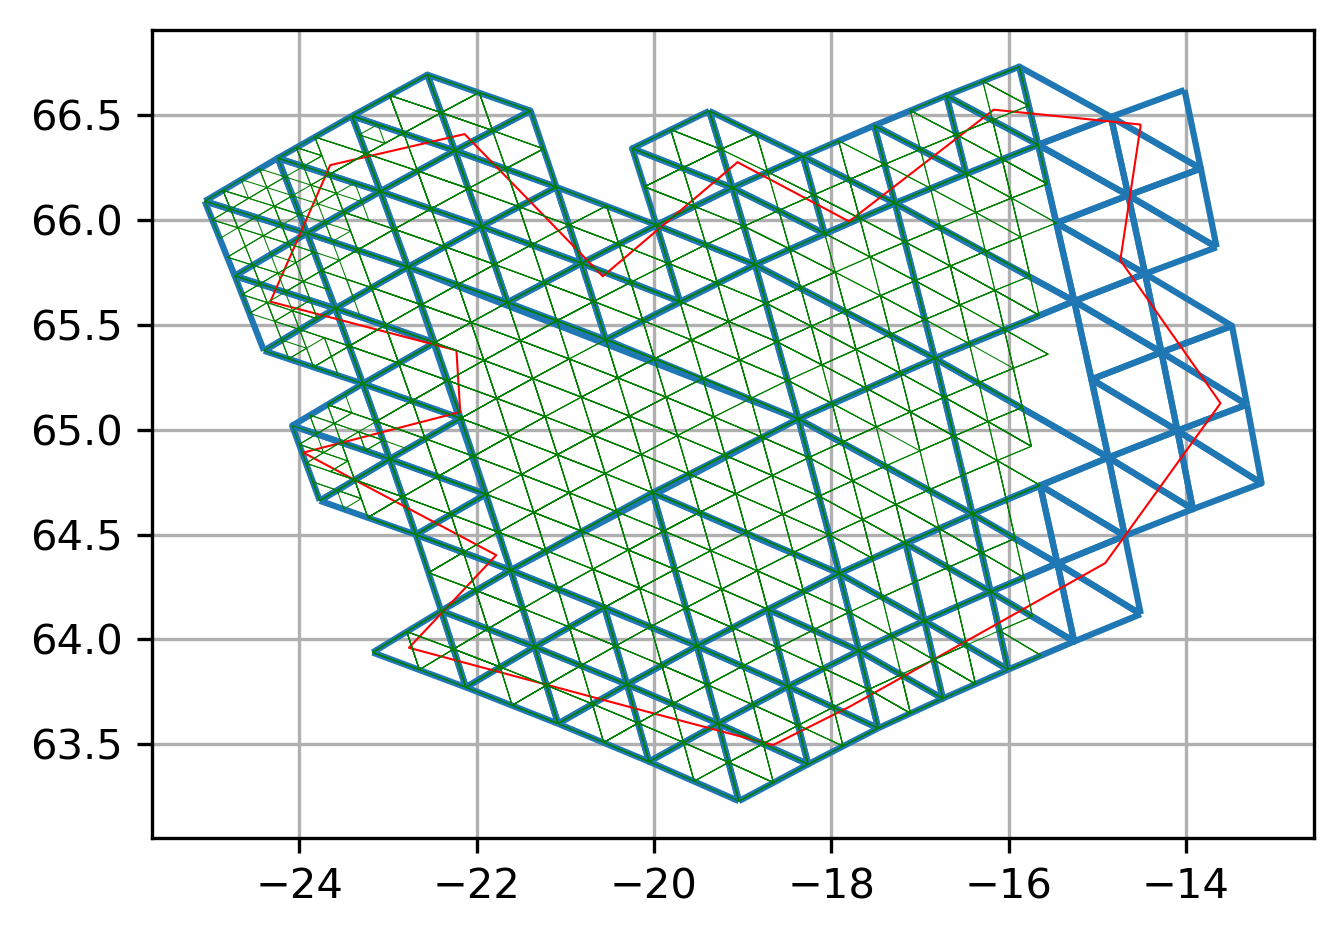

In [29]:
fig, ax = plt.subplots(figsize=(5,5), dpi=300)
ax.grid(True)

iceland.plot(ax=ax)
iceland.plot(ax=ax, trixels=False, boundary=True, linewidth=0.5, color='red')

modis[intersects_stare].plot(ax=ax, markersize=0.1, color='g', linewidth=0.25)

# Parallel

In [17]:
fname = 'VNP03DNB.A2020219.0742.001.2020219124651.nc'

n_workers = 50
sids_series = modis['sids']
ddf = dask.dataframe.from_pandas(sids_series, npartitions=n_workers)

In [18]:
meta = {'intersects': 'bool'}
res = ddf.map_partitions(lambda df: pystare.intersects(sids_iceland, df, 1), meta=meta)

In [19]:
a = res.compute(scheduler='processes')

In [20]:
len(a)

109620

In [21]:
intersects_stare = pystare.intersects(sids_iceland, sids_modis)

In [22]:
len(intersects_stare)

109620